# Quantile Regression

In [1]:
import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pandas_datareader as pdr
import cvxpy as cvx

## 1. Build Data

 - Period: 2009/12/31-2018/4/30
 - Stock: **NYSE DIS** (Walt Disney Co.)
 - Factors: Fama-French 3 factors - Mkt, Size(SMB), Value(HML)

In [2]:
tiingo_key = open('/Users/jenchiehcheng/tiingo/tiingo_key.txt').read()
start = datetime.datetime(2009, 12, 31)
end = datetime.datetime(2018, 4, 30)

# load stock price
tickers = ['DIS']
px = pdr.DataReader(tickers, data_source='tiingo', start=start, end=end, access_key=tiingo_key)
close_px = pd.concat([px.loc[ticker, 'adjClose'] for ticker in tickers], axis=1)
close_px.columns = tickers
ret = close_px.pct_change()

# load factor returns
FF = pdr.DataReader('F-F_Research_Data_Factors_daily', 'famafrench', start=start, end=end)
FF[0] = FF[0] / 100
rm = FF[0]['Mkt-RF']
rf = FF[0]['RF']

# create data
re = pd.concat([FF[0]] + [ret[ticker] - rf for ticker in tickers], axis=1)
re.columns = FF[0].columns.tolist() + tickers
re.dropna(inplace=True)

re['Const'] = 1

re.head()

,Mkt-RF,SMB,HML,RF,DIS,Const
2010-01-04,0.0169,0.0058,0.0112,0.0,-0.005581,1
2010-01-05,0.0031,-0.0059,0.0122,0.0,-0.002495,1
2010-01-06,0.0013,-0.0025,0.0052,0.0,-0.005314,1
2010-01-07,0.0040,0.0008,0.0094,0.0,0.000314,1
2010-01-08,0.0033,0.0040,0.0001,0.0,0.001571,1


## 2. Optimization

Given desired quantile $q \in (0, 1)$, find $\beta$ such that the cost function:

$$
\frac{1}{T}\sum_t^T \left[q \left(y_t-\hat{y}_t^{(q)} \right)^+ - (1-q) \left(y_t-\hat{y}_t^{(q)} \right)^-\right] + \lambda \| \beta\|_2^2
$$

is minimized, where

$$\hat{y}_t^{(q)} =  \beta_0 + \sum_{i=1}^K \beta_i F_{i, t} $$

In [3]:
def quantile_reg(Y, X, quantile=0.5, lamb=0.01):
    
    y, x = np.array(Y), np.array(X)
    T, K = X.shape
    
    b = cvx.Variable(K)
    u = y - x * b
    
    J = (quantile * cvx.sum_entries(cvx.pos(u)) + (1 - quantile) * cvx.sum_entries(cvx.neg(u))) / T
    L2 = cvx.norm(b) ** 2
    
    prob = cvx.Problem(cvx.Minimize(J + lamb * L2))
    prob.solve()
    
    return np.asarray(b.value).reshape(-1)

def pred(X, b):
    return X.dot(b)

def error(Y, Y_pred, quantile):
    u = Y - Y_pred
    return (quantile * u[u > 0].sum() + (quantile - 1) * u[u < 0].sum()) / Y.shape[0]

def metric(Y, Y_pred):
    return (Y < Y_pred).sum() / Y.shape[0]

##  3. Cross-validation

In [4]:
def time_serires_split(ix, split=[0.8, 0.2]):
    
    n_split = len(split)
    T = len(ix)
    idx = 0
    partition = []
    for i, r in enumerate(split):
        if i != n_split - 1:
            segment = int(T * r)
            partition.append(ix[idx: idx + segment])
            idx = idx + segment
        else:
            partition.append(ix[idx:])

    return partition

In [5]:
factors = re[['Const', 'Mkt-RF', 'SMB', 'HML']]
train, cv, test = time_serires_split(re.index, [0.6, 0.2, 0.2])

print('Train size: %d, '%len(train), train[0], train[-1])
print('Train size: %d, '%len(cv), cv[0], cv[-1])
print('Train size: %d, '%len(test), test[0], test[-1])

Train size: 1257,  2010-01-04 00:00:00 2014-12-30 00:00:00
Train size: 419,  2014-12-31 00:00:00 2016-08-29 00:00:00
Train size: 419,  2016-08-30 00:00:00 2018-04-30 00:00:00


In [6]:
# simple random search for hyperparameter lambda
np.random.seed(10)
L = np.random.uniform(0, 0.0005, size=10)
Q = [0.05, 0.5, 0.95]

b = {}
lamb = {}

for q in Q:
    E = np.inf    
    for l in L:
        
        # estimate coefficient from test set
        temp_b = quantile_reg(re.loc[train, 'DIS'], factors.loc[train, :], quantile=q, lamb=l)
        
        # evaluate error on cross-validation set
        temp_error = error(re.loc[cv, 'DIS'], pred(factors.loc[cv, :], temp_b), q)
        
        #print(q, l, temp_error)
        if temp_error < E:
            b[q], lamb[q], E = temp_b, l, temp_error

## 4. Performance Measure

In [7]:
r = {}

for q in Q:
    r_pred = pred(factors.loc[test, :], b[q])
    r['q=%.2f, lambda=%.5f'%(q, lamb[q])] = r_pred
    print('P(r < r(q=%.2f)) = %.5f'%(q, metric(re.loc[test, 'DIS'], r_pred)))

P(r < r(q=0.05)) = 0.07637
P(r < r(q=0.50)) = 0.51074
P(r < r(q=0.95)) = 0.95943


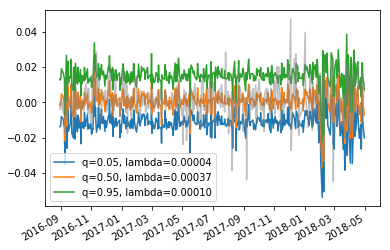

In [8]:
r = pd.DataFrame(r)
r.plot()
re.loc[test, 'DIS'].plot(color='gray', alpha=0.5)

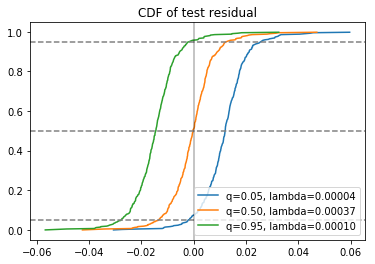

In [9]:
for c in r.columns:
    u = re.loc[test, 'DIS'].values.reshape(-1) - r[c]
    plt.plot(sorted(u), np.arange(0, 1, 1 / u.shape[0]), label=c)

plt.axhline(0.05, color='gray', ls='--')
plt.axhline(0.50, color='gray', ls='--')
plt.axhline(0.95, color='gray', ls='--')
plt.axvline(0, color='k', alpha=0.3)
plt.title('CDF of test residual')
plt.legend()